<a href="https://colab.research.google.com/github/cccg8105/notebook_AD/blob/master/template%20Series%20temporales/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Red neuronal recurrente

## Importar datos

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('https://raw.githubusercontent.com/cccg8105/curso-series-temporales/master/13.%20Redes%20Neuronales/Python/Alcohol_Sales.csv',index_col='DATE',parse_dates=True)
df.index.freq = 'MS'
df.columns = ['Sales']

df.sample(10)

,Sales
DATE,
2016-02-01,10324
2016-08-01,12705
2006-05-01,8843
2004-03-01,7045
1995-08-01,5000
1994-11-01,4784
2005-01-01,5557
2018-07-01,12518
2002-04-01,6525


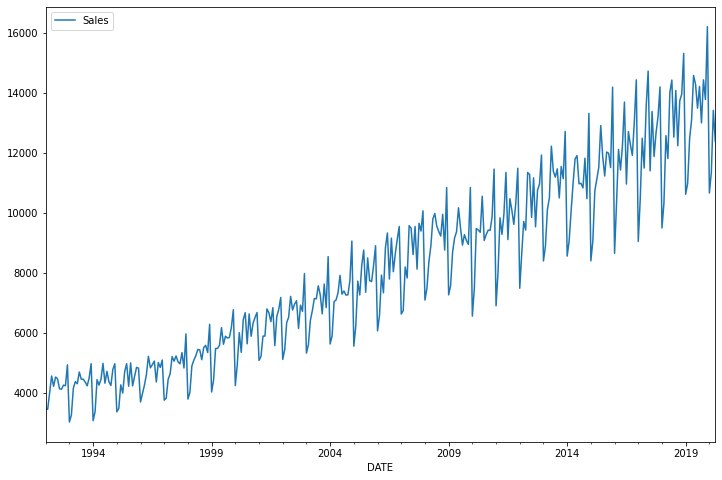

In [4]:
df.plot(figsize=(12,8))

## Descomposición de la serie

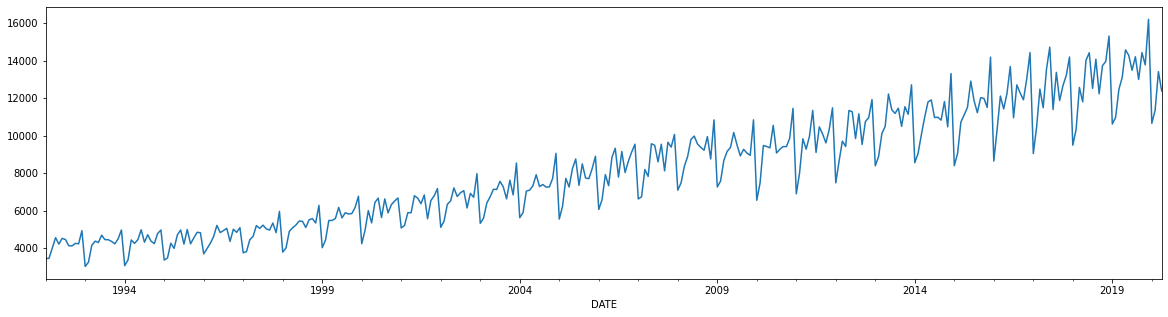

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

results = seasonal_decompose(df['Sales'])
results.observed.plot(figsize=(20,5))

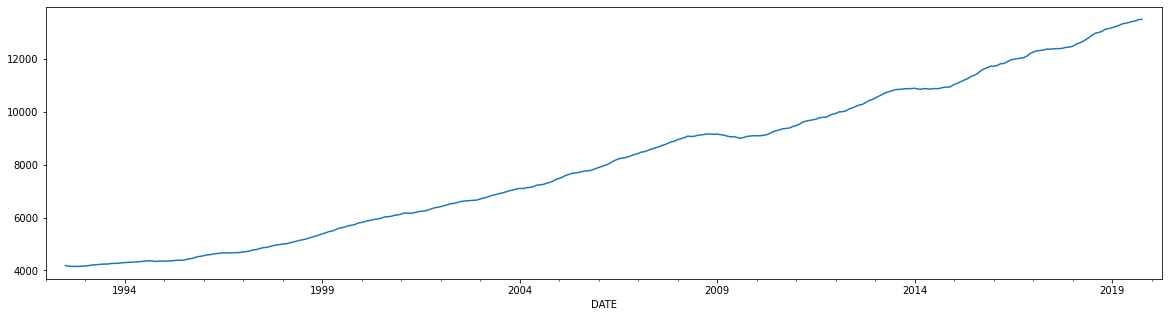

In [7]:
results.trend.plot(figsize=(20,5))

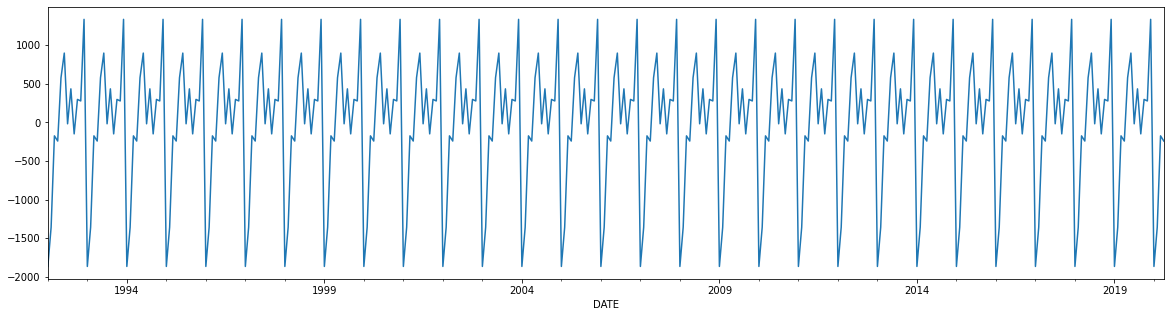

In [8]:
results.seasonal.plot(figsize=(20,5))

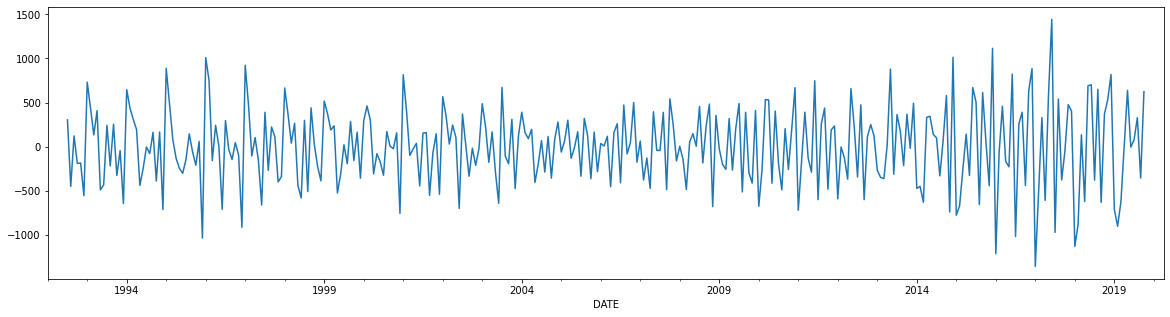

In [9]:
results.resid.plot(figsize=(20,5))

## División de datos

In [22]:
cantidadPeriodosTest = 12
train = df.iloc[:len(df)-cantidadPeriodosTest]
test = df.iloc[len(df)-cantidadPeriodosTest:]

## Escalado de datos

In [23]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## Generar serie temporal

In [25]:
from keras.preprocessing.sequence import TimeseriesGenerator

# Definimos el generator
n_input = 12 # este valor deberia depender del valor estacional
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

print(len(generator)) # n_input = 2

X,y = generator[0]

print(f'Datos: \n{X.flatten()}')
print(f'Predicción: \n {y}')

316
Datos: 
[0.03486194 0.03478048 0.07909098 0.12486764 0.09692922 0.12201678
 0.11688523 0.09008715 0.08919117 0.10002444 0.09847683 0.1551682 ]
Predicción: 
 [[0.]]


## Modelo red recurrente

In [27]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [28]:
# entrenamiento con datos de entrada
model.fit_generator(generator,epochs=50)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
316/316 [==============================] - 2s 6ms/step - loss: 0.0171
Epoch 2/50
316/316 [==============================] - 2s 5ms/step - loss: 0.0090
Epoch 3/50
316/316 [==============================] - 2s 5ms/step - loss: 0.0089
Epoch 4/50
316/316 [==============================] - 2s 5ms/step - loss: 0.0084
Epoch 5/50
316/316 [==============================] - 2s 5ms/step - loss: 0.0065
Epoch 6/50
316/316 [==============================] - 2s 5ms/step - loss: 0.0056
Epoch 7/50
316/316 [==============================] - 2s 5ms/step - loss: 0.0044
Epoch 8/50
316/316 [==============================] - 2s 5ms/step - loss: 0.0040
Epoch 9/50
316/316 [==============================] - 2s 5ms/step - loss: 0.0033
Epoch 10/50
316/316 [==============================] - 2s 5ms/step - loss: 0.0028
Epoch 11/50
316/316 [==============================] - 2s 5ms/step - loss: 0.0026
Epoch 12/50
316/316 [==========

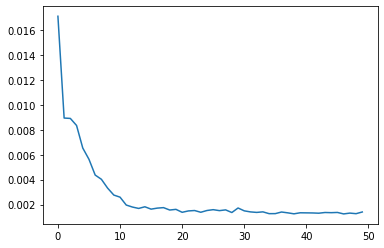

In [29]:
model.history.history.keys()
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

## Evaluar datos de prueba

In [30]:
# 12 meses de historia ---> predecir el 13
# Necesitaremos los últimos 12 meses del conjunto de entrenamiento para predecir el 1er mes en el conjunto de prueba
first_eval_batch = scaled_train[-12:]
first_eval_batch
# Se transforma la estructura de datos
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

model.predict(first_eval_batch)

array([[0.9403371]], dtype=float32)

In [31]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [32]:
print(test_predictions)
print(scaled_test)

[array([0.9403371], dtype=float32), array([0.9637626], dtype=float32), array([0.828988], dtype=float32), array([0.95047265], dtype=float32), array([0.80429363], dtype=float32), array([0.9342588], dtype=float32), array([0.9396122], dtype=float32), array([1.0456655], dtype=float32), array([0.64546245], dtype=float32), array([0.7149105], dtype=float32), array([0.81814927], dtype=float32), array([0.8753456], dtype=float32)]
[[0.94013195]
 [0.91602183]
 [0.8514295 ]
 [0.9101572 ]
 [0.81135457]
 [0.9282398 ]
 [0.87496946]
 [1.07241183]
 [0.62132443]
 [0.67760854]
 [0.84540197]
 [0.76134235]]


### Conversión de datos escalados

In [33]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions

test

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Sales,Predictions
DATE,,
2019-05-01,14573,14575.518840
2019-06-01,14277,14863.113211
2019-07-01,13484,13208.485868
2019-08-01,14205,14699.952760
2019-09-01,12992,12905.312926
2019-10-01,14427,14500.895516
2019-11-01,13773,14566.619100
2019-12-01,16197,15868.635375
2020-01-01,10659,10955.342540


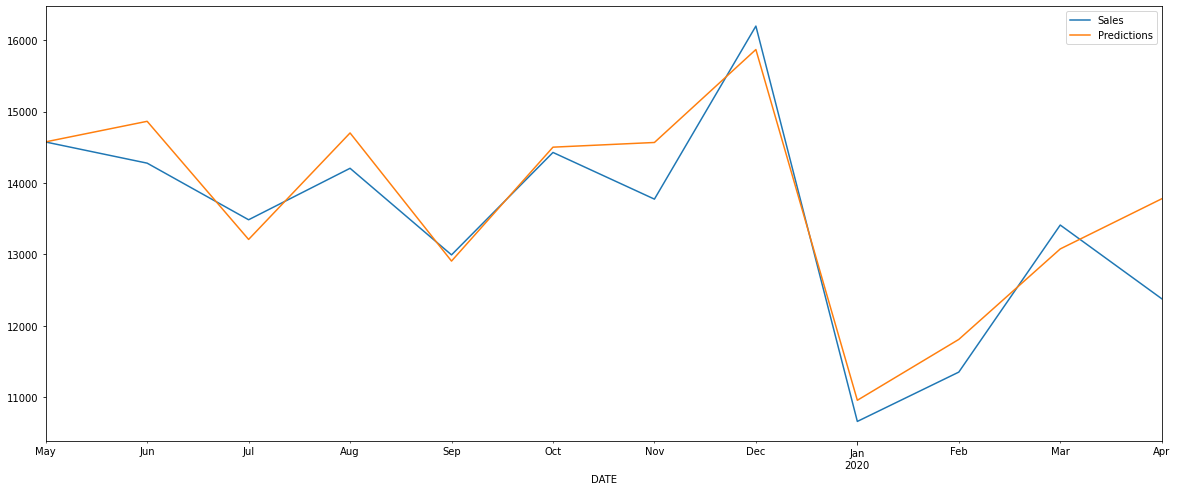

In [34]:
test.plot(figsize=(20,8))

### Guardar modelo

In [35]:
model.save('my_rnn_model.h5')

## Cargar modelo

In [36]:
from keras.models import load_model
new_model = load_model('my_rnn_model.h5')

new_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
